# EMCEE vs Nautilus – Joint Posterior

- run **Nautilus** and/or **emcee**, *or* just load existing runs,
- convert both into the **same posterior format**,
- make an **overlaid corner plot** of the common parameters,

Edit the config cell below and then run the notebook top-to-bottom.


In [27]:
# ==========================
# USER CONFIGURATION
# ==========================

# --- Which system to analyse ---
BASE_DIR = "."  # folder that contains TDC data & results
RUNG = 2
CODE_ID = 1
SEED = 119

# --- Control which samplers to run or load ---
# If RUN_* is True, the sampler is run now (and may take a while).
# If RUN_* is False but LOAD_* is True, existing runs are loaded from disk.
RUN_MULTISTARTS = False

RUN_NAUTILUS = False
RUN_EMCEE = False

LOAD_NAUTILUS = True
LOAD_EMCEE = True

NUMBER_MULTISTARTS = 20  # number of multistarts to perform
# Nautilus checkpoint (HDF5) and configuration
NAUTILUS_N_LIVE = 1000
NAUTILUS_CKPT_PATH = (
    f"nautilus_output/run_checkpoint_rung{RUNG}_seed{SEED}_{NAUTILUS_N_LIVE}.hdf5"
)

# emcee backend (HDF5) and configuration
EMCEE_N_WALKERS = 64
EMCEE_N_STEPS = 5000
EMCEE_BACKEND_PATH = (
    f"emcee_output/emcee_chain_rung{RUNG}_seed{SEED}_"
    f"walkers{EMCEE_N_WALKERS}_steps{EMCEE_N_STEPS}.h5"
)

# --- Posterior sample sizes ---
# None => use all available samples after burn-in / resampling.
NAUTILUS_N_SAMPLES = 5000   # for importance-resampled Nautilus posterior
EMCEE_N_SAMPLES = 5000      # for post-burnin emcee posterior

# Burn-in & thinning for emcee
EMCEE_BURNIN_FRACTION = 0.5   # discard first 50% of steps as burn-in
EMCEE_THIN = 1                # keep every EMCEE_THIN-th step

# --- Corner plot parameter selection ---
# PARAMS_TO_CORNER = None  -> auto: common parameters (up to MAX_PARAMS_FOR_CORNER)
# PARAMS_TO_CORNER = ["lens_theta_E", "lens_gamma", ...] -> manual selection
PARAMS_TO_CORNER = [
    "lens_theta_E",
    "lens_gamma",
    "lens_e1",
    "lens_e2",
    "light_Re_L",
    "light_n_L",
    "light_e1_L",
    "light_e2_L",
]
MAX_PARAMS_FOR_CORNER = 10

# --- H0 calculation settings ---
# CALCULATE_H0: "none", "nautilus", "emcee", or "both".
CALCULATE_H0 = "both"
H0_PARAM_NAME = "H0"       # adapt this to your parameter name
H0_QUANTILES = [16, 50, 84] # e.g. 16-50-84 percentiles

# Random seed used for any resampling / subsampling
RANDOM_SEED = 42


In [28]:
# ==========================
# Imports & lens model setup
# ==========================

import os
from pathlib import Path
import json

import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee

BASE_DIR = Path(BASE_DIR).expanduser()
print("Base directory:", BASE_DIR)

# Make sure BASE_DIR is on the Python path, in case the tdlmc_*.py live there
import sys
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

from tdlmc_model import setup_tdlmc_lens, tdlmc_paths
from tdlmc_inference import (
    run_multistart,
    load_multistart_summary,
    build_nautilus_prior_and_loglike,
    build_emcee_prior,
    build_emcee_logprob,
    draw_emcee_initial_positions,
    run_nautilus,
    run_emcee,
    load_posterior_from_checkpoint,
    get_nautilus_posterior,
    get_emcee_posterior,
)

# --- Build lens model & get outdir ---
lens_setup = setup_tdlmc_lens(
    base=str(BASE_DIR),
    rung=RUNG,
    code_id=CODE_ID,
    seed=SEED,
)

prob_model = lens_setup["prob_model"]
lens_image = lens_setup["lens_image"]
img = lens_setup["img"]
noise_map = lens_setup["noise_map"]
outdir = lens_setup["outdir"]

print("Outdir:", outdir)


Base directory: .
Outdir: ./TDC_results/rung2/code1/f160w-seed119


In [29]:
import time

if not RUN_MULTISTARTS:
    print("Skipping multistart and loading previous results...")
else:
    t_0 = time.time()
    summary = run_multistart(
        prob_model,
        img,
        noise_map,
        outdir=outdir,
        n_starts=NUMBER_MULTISTARTS,
        random_seed=73,
        do_preopt=True,
    )
    t_1 = time.time()
    print(f"Total runtime: {t_1 - t_0:.2f} seconds ({(t_1 - t_0)/60:.2f} min)")

# --- Benchmarking for multi-start (timing, χ², etc.) ---
ms_bench_dir = os.path.join(outdir, "benchmarks", "multistart")
os.makedirs(ms_bench_dir, exist_ok=True)

# --- Load multi-start summary & best-fit parameters ---
summary = load_multistart_summary(outdir, verbose=True)
best_params = summary["best_params_json"]

print("Multi-start best-fit parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Skipping multistart and loading previous results...
Loaded summary from: ./TDC_results/rung2/code1/f160w-seed119/multi_start_summary.json
Loaded best-fit parameters from: ./TDC_results/rung2/code1/f160w-seed119/best_fit_params_run04.json
Multi-start best-fit parameters:
  lens_center_x: -0.036302246153354645
  lens_center_y: 0.024007264524698257
  lens_theta_E: 1.213606357574463
  lens_e1: 0.16694608330726624
  lens_e2: 0.04524129629135132
  lens_gamma: 1.8348019123077393
  lens_gamma1: 0.1296495795249939
  lens_gamma2: 0.06597030162811279
  light_amp_L: 50.58680725097656
  light_Re_L: 1.0124720335006714
  light_n_L: 3.1409525871276855
  light_e1_L: 0.03535336256027222
  light_e2_L: -0.16850855946540833
  light_amp_S: 9.404234886169434
  light_Re_S: 0.531196117401123
  light_n_S: 2.386341094970703
  light_e1_S: -0.2648559808731079
  light_e2_S: 0.052039921283721924
  src_center_x: -0.031152669340372086
  src_center_y: 0.0418882817029953
  x_image: [-1.156150460243225, 1.053593993186950

In [30]:
# ==========================
# Nautilus: run or load, then standard posterior
# ==========================

post_nautilus = None
sampler_nautilus = None

if RUN_NAUTILUS or LOAD_NAUTILUS:
    # Build prior & log-likelihood around the best-fit params
    prior_naut, paramdict_to_kwargs_naut, loglike_naut = build_nautilus_prior_and_loglike(
        best_params, lens_image, img, noise_map
    )

if RUN_NAUTILUS:
    # Ensure checkpoint directory exists
    ckpt_dir = os.path.dirname(NAUTILUS_CKPT_PATH)
    if ckpt_dir:
        os.makedirs(ckpt_dir, exist_ok=True)

    sampler_nautilus, points_nautilus, log_w_nautilus, log_l_nautilus = run_nautilus(
        prior=prior_naut,
        loglike=loglike_naut,
        n_live=NAUTILUS_N_LIVE,
        filepath=NAUTILUS_CKPT_PATH,
        resume=False,
        verbose=True,
    )
elif LOAD_NAUTILUS:
    # Load posterior from an existing Nautilus checkpoint
    sampler_nautilus, points_nautilus, log_w_nautilus, log_l_nautilus = load_posterior_from_checkpoint(
        prior=prior_naut,
        loglike=loglike_naut,
        n_live=NAUTILUS_N_LIVE,
        filepath=NAUTILUS_CKPT_PATH,
    )
else:
    print("Skipping Nautilus entirely (RUN_NAUTILUS == False and LOAD_NAUTILUS == False).")

if RUN_NAUTILUS or LOAD_NAUTILUS:
    post_nautilus = get_nautilus_posterior(
        sampler=sampler_nautilus,
        points=points_nautilus,
        log_w=log_w_nautilus,
        log_l=log_l_nautilus,
        n_samples=NAUTILUS_N_SAMPLES,
        random_seed=RANDOM_SEED,
        use_weights=True,
    )
    print("Nautilus posterior samples shape:", post_nautilus["samples"].shape)


Nautilus posterior samples shape: (5000, 32)


In [31]:
# ==========================
# emcee: run or load, then standard posterior
# ==========================

post_emcee = None
sampler_emcee = None

if RUN_EMCEE or LOAD_EMCEE:
    # Build prior & log-probability around the best-fit params
    param_names_emcee, prior_dists_emcee, best_flat_emcee, nps_emcee = build_emcee_prior(best_params)
    log_prob_emcee, paramdict_to_kwargs_emcee, loglike_emcee = build_emcee_logprob(
        param_names_emcee,
        prior_dists_emcee,
        best_flat_emcee,
        nps_emcee,
        lens_image,
        img,
        noise_map,
    )

if RUN_EMCEE:
    # Draw initial walker positions from the prior
    p0 = draw_emcee_initial_positions(
        prior_dists_emcee,
        n_walkers=EMCEE_N_WALKERS,
        random_seed=RANDOM_SEED,
    )

    backend_dir = os.path.dirname(EMCEE_BACKEND_PATH)
    if backend_dir:
        os.makedirs(backend_dir, exist_ok=True)

    sampler_emcee, chain_emcee, log_prob_chain_emcee, emcee_summary = run_emcee(
        log_prob_emcee,
        p0,
        n_steps=EMCEE_N_STEPS,
        backend_path=EMCEE_BACKEND_PATH,
        progress=True,
    )
elif LOAD_EMCEE:
    backend = emcee.backends.HDFBackend(EMCEE_BACKEND_PATH, read_only=True)
    chain_emcee = backend.get_chain()
    log_prob_chain_emcee = backend.get_log_prob()
    sampler_emcee = None
else:
    print("Skipping emcee entirely (RUN_EMCEE == False and LOAD_EMCEE == False).")

if RUN_EMCEE or LOAD_EMCEE:
    post_emcee = get_emcee_posterior(
        chain=chain_emcee,
        log_prob_chain=log_prob_chain_emcee,
        param_names=param_names_emcee,
        burnin_fraction=EMCEE_BURNIN_FRACTION,
        thin=EMCEE_THIN,
        n_samples=EMCEE_N_SAMPLES,
        random_seed=RANDOM_SEED,
    )
    print("emcee posterior samples shape:", post_emcee["samples"].shape)


emcee posterior samples shape: (5000, 32)


Corner parameters: ['lens_theta_E', 'lens_gamma', 'lens_e1', 'lens_e2', 'light_Re_L', 'light_n_L', 'light_e1_L', 'light_e2_L']
Removed no burn in
Removed no burn in
Reading lens info from: ./TDC/rung2_open_box/code1/f160w-seed119/lens_all_info.txt
Saved joint Nautilus/emcee corner plot to: ./TDC_results/rung2/code1/f160w-seed119/corner_nautilus_vs_emcee.png


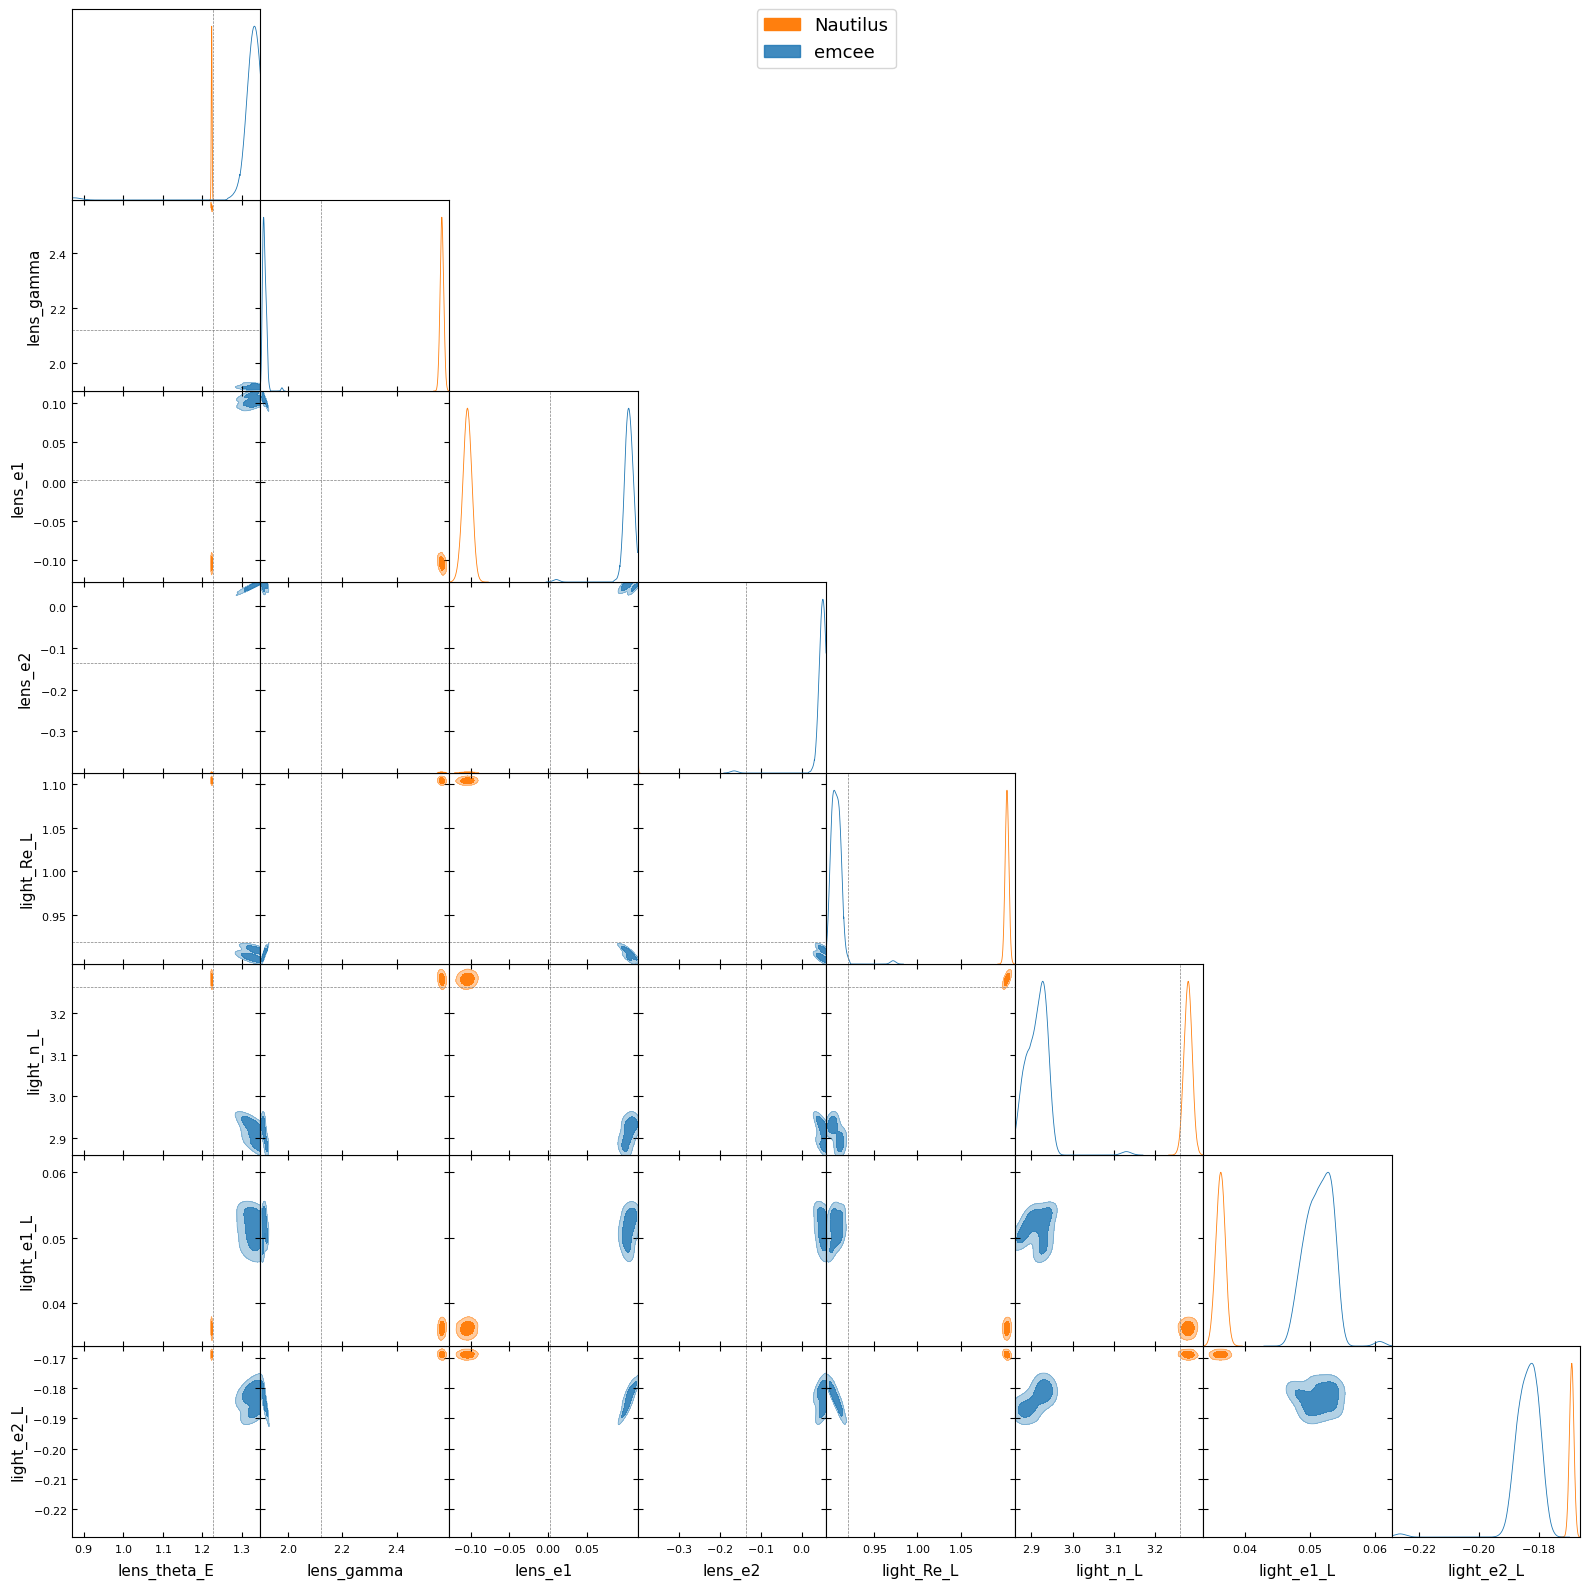

In [32]:
# --- JOINT GETDIST CORNER: Nautilus (blue) vs emcee (orange) ---

from getdist import MCSamples, plots
from TDC_util import parse_lens_info_file

# Falls noch nicht gesetzt: param_names für Nautilus aus dem Prior übernehmen
if post_nautilus is not None and post_nautilus.get("param_names") is None:
    post_nautilus["param_names"] = list(prior_naut.keys)

# Parameters you want in the corner
params_to_corner = PARAMS_TO_CORNER
if params_to_corner is None:
    # Auto-select up to MAX_PARAMS_FOR_CORNER common parameters
    candidate_params = []
    if post_nautilus is not None and post_nautilus["param_names"] is not None:
        candidate_params.extend(post_nautilus["param_names"])
    if post_emcee is not None and post_emcee["param_names"] is not None:
        candidate_params.extend(post_emcee["param_names"])
    # Keep order and uniqueness
    seen = set()
    candidate_params = [p for p in candidate_params if not (p in seen or seen.add(p))]

    params_to_corner = candidate_params[:MAX_PARAMS_FOR_CORNER]
    print(f"Auto-selected parameters for corner plot (up to {MAX_PARAMS_FOR_CORNER}):")
    print(params_to_corner)

# Helper: figure out which params are common to the available posteriors
def get_common_corner_names(params_to_corner, post_nautilus, post_emcee):
    name_sets = []
    if (post_nautilus is not None) and (post_nautilus["param_names"] is not None):
        name_sets.append(set(post_nautilus["param_names"]))
    if (post_emcee is not None) and (post_emcee["param_names"] is not None):
        name_sets.append(set(post_emcee["param_names"]))

    if not name_sets:
        raise RuntimeError("No posterior samples (Nautilus/emcee) available.")

    common = set(params_to_corner)
    for s in name_sets:
        common &= s

    corner_names = [p for p in params_to_corner if p in common]
    if not corner_names:
        raise RuntimeError(
            "None of the requested params_to_corner are common to the available "
            "posteriors. Please adjust params_to_corner."
        )
    return corner_names

corner_names = get_common_corner_names(params_to_corner, post_nautilus, post_emcee)
print("Corner parameters:", corner_names)

# Helper: extract samples array in the right order from a standardised posterior dict
def extract_corner_samples(posterior, corner_names):
    if posterior is None or posterior["param_names"] is None:
        return None
    pnames = posterior["param_names"]
    idx = [pnames.index(p) for p in corner_names]
    return posterior["samples"][:, idx]

corner_samples_naut = extract_corner_samples(post_nautilus, corner_names)
corner_samples_em   = extract_corner_samples(post_emcee, corner_names)

if (corner_samples_naut is None) and (corner_samples_em is None):
    raise RuntimeError("No samples found for the requested corner parameters.")

# GetDist MCSamples with a bit of smoothing
settings_mcsamples = {
    "smooth_scale_1D": 0.5,
    "smooth_scale_2D": 0.5,
}

samples_for_plot = []
legend_labels = []

if corner_samples_naut is not None:
    mcs_naut = MCSamples(
        samples=corner_samples_naut,
        names=corner_names,
        settings=settings_mcsamples,
    )
    samples_for_plot.append(mcs_naut)
    legend_labels.append("Nautilus")

if corner_samples_em is not None:
    mcs_em = MCSamples(
        samples=corner_samples_em,
        names=corner_names,
        settings=settings_mcsamples,
    )
    samples_for_plot.append(mcs_em)
    legend_labels.append("emcee")

# -------------------------
# Load truth values
# -------------------------
code = f"code{CODE_ID}"
truth_file = os.path.join(
    BASE_DIR,
    f"TDC/rung{RUNG}_open_box/{code}/f160w-seed{SEED}/lens_all_info.txt",
)
print("Reading lens info from:", truth_file)
lens_info = parse_lens_info_file(truth_file)

def _phi_to_rad(phi):
    return np.deg2rad(phi) if np.abs(phi) > 2 * np.pi else float(phi)

def _e1e2_from_q_phi(q, phi):
    e = (1 - q) / (1 + q)
    return e * np.cos(2 * phi), e * np.sin(2 * phi)

thetaE_true = lens_info["lens_mass_model"]["SPEMD"]["theta_E"]
gamma_true = lens_info["lens_mass_model"]["SPEMD"]["gamma"]
q_mass = lens_info["lens_mass_model"]["SPEMD"]["q"]
phi_mass = _phi_to_rad(lens_info["lens_mass_model"]["SPEMD"].get("phi_G", 0.0))
e1_mass_true, e2_mass_true = _e1e2_from_q_phi(q_mass, phi_mass)

q_light = lens_info["lens_light"]["q"]
phi_light = _phi_to_rad(lens_info["lens_light"]["phi_G"])
e1_L_true, e2_L_true = _e1e2_from_q_phi(q_light, phi_light)
R_true = lens_info["lens_light"]["R_sersic"]
n_true = lens_info["lens_light"]["n_sersic"]

truth_values = {
    "lens_theta_E": thetaE_true,
    "lens_gamma": gamma_true,
    "lens_e1": e1_mass_true,
    "lens_e2": e2_mass_true,
    "light_Re_L": R_true,
    "light_n_L": n_true,
    "light_e1_L": e1_L_true,
    "light_e2_L": e2_L_true,
}
truth_markers = [truth_values[name] for name in corner_names]

# -------------------------
# Plot with getdist: Nautilus = blue, emcee = orange
# -------------------------
g = plots.get_subplot_plotter(subplot_size=2)
g.settings.legend_fontsize = 16
g.settings.axes_labelsize = 14

g.settings.solid_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

g.triangle_plot(
    samples_for_plot,
    params=corner_names,
    legend_labels=legend_labels,
    filled=True,
    markers=truth_markers,
)

corner_path = os.path.join(outdir, "corner_nautilus_vs_emcee.png")
g.export(corner_path, dpi=300)
print("Saved joint Nautilus/emcee corner plot to:", corner_path)


Nautilus: using posterior sample #2922


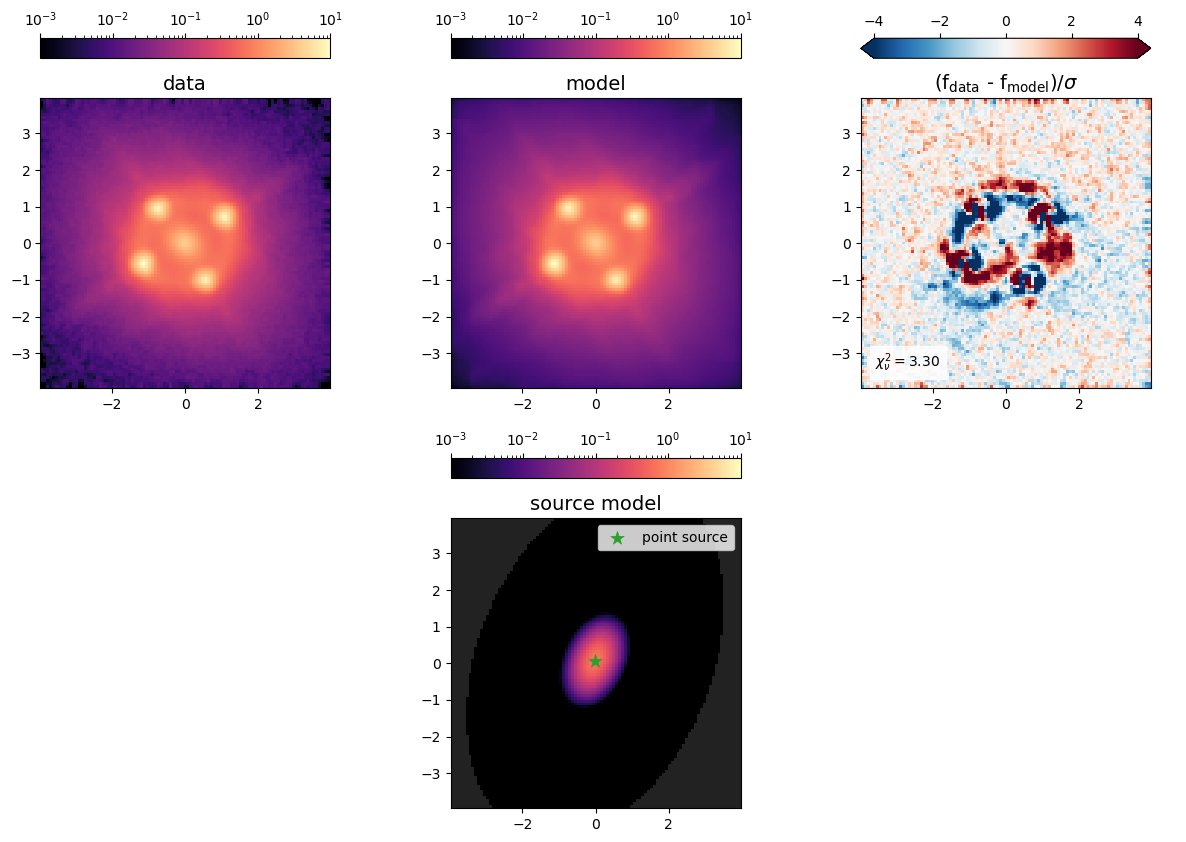

[Nautilus] chi^2 = 32362.89,  chi^2_red = 3.313
emcee: using posterior sample #2313


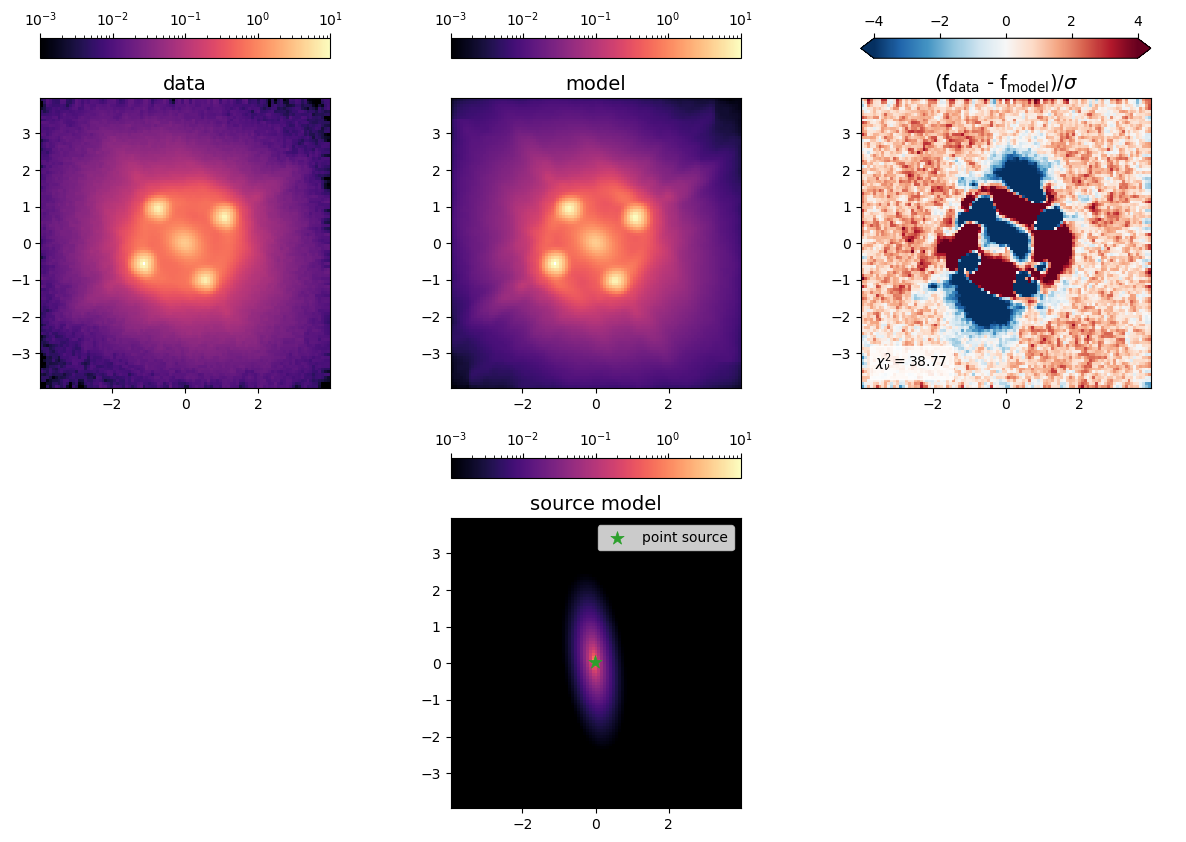

[emcee]    chi^2 = 379955.06,  chi^2_red = 38.894


In [ ]:
# ==========================
# One posterior draw from Nautilus & emcee + model_summary plots
# ==========================

from herculens.Analysis.plot import Plotter

rng = np.random.default_rng(RANDOM_SEED + 123)

plotter = Plotter(flux_vmin=1e-3, flux_vmax=10, res_vmax=4)

# Attach the observed data (from your lens setup)
plotter.set_data(img)

def draw_kwargs_from_posterior(posterior, paramdict_to_kwargs, label):
    """Draw a single posterior sample and convert it to kwargs_* for lens_image."""
    if posterior is None or posterior.get("samples") is None:
        print(f"{label}: no posterior available.")
        return None, None
    if posterior.get("param_names") is None:
        print(f"{label}: posterior['param_names'] is None.")
        return None, None

    samples = posterior["samples"]
    names = posterior["param_names"]

    idx = int(rng.integers(0, samples.shape[0]))
    theta = samples[idx]
    sample_dict = {name: float(val) for name, val in zip(names, theta)}
    kwargs = paramdict_to_kwargs(sample_dict)
    print(f"{label}: using posterior sample #{idx}")
    return kwargs, idx


# ---------- Nautilus draw ----------
kwargs_naut, idx_naut = draw_kwargs_from_posterior(
    post_nautilus, paramdict_to_kwargs_naut, "Nautilus"
)

if kwargs_naut is not None:
    fig = plotter.model_summary(
        lens_image,
        kwargs_naut,
        show_source=True,
        kwargs_grid_source=dict(pixel_scale_factor=1),
    )
    fig.suptitle(f"Nautilus posterior draw #{idx_naut}", fontsize=14)
    fig.savefig(
        os.path.join(outdir, f"nautilus_posterior_draw_{idx_naut}.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Residuals & chi^2
    model_img_naut = lens_image.model(**kwargs_naut)
    resid_naut = (img - model_img_naut) / (noise_map + 1e-12)
    chi2_naut = float(np.sum(resid_naut**2))
    dof_naut = img.size - prob_model.num_parameters
    print(f"[Nautilus] chi^2 = {chi2_naut:.2f},  chi^2_red = {chi2_naut / max(1, dof_naut):.3f}")


# ---------- emcee draw ----------
kwargs_emcee_draw, idx_emcee = draw_kwargs_from_posterior(
    post_emcee, paramdict_to_kwargs_emcee, "emcee"
)

if kwargs_emcee_draw is not None:
    fig = plotter.model_summary(
        lens_image,
        kwargs_emcee_draw,
        show_source=True,
        kwargs_grid_source=dict(pixel_scale_factor=1),
    )
    fig.suptitle(f"emcee posterior draw #{idx_emcee}", fontsize=14)
    fig.savefig(
        os.path.join(outdir, f"emcee_posterior_draw_{idx_emcee}.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Residuals & chi^2
    model_img_em = lens_image.model(**kwargs_emcee_draw)
    resid_em = (img - model_img_em) / (noise_map + 1e-12)
    chi2_em = float(np.sum(resid_em**2))
    dof_em = img.size - prob_model.num_parameters
    print(f"[emcee]    chi^2 = {chi2_em:.2f},  chi^2_red = {chi2_em / max(1, dof_em):.3f}")
